### PRELIMINARY ETL PIPELINE

In [1]:
import pandas as pd
import numpy as np
import os
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
os.getcwd().replace('notebook','data')

'C:\\Users\\bonano1m\\Documents\\capstone\\data'

In [3]:
file_name_1 = 'elspot-prices_'
file_name_2 = '_hourly_dkk.csv'
years = ['2013','2014','2015']
data_folder = os.getcwd().replace('notebook','data\\')
all_data=[]
for year in years:
    file_name_tot = data_folder + file_name_1 + year + file_name_2
    all_data.append(pd.read_csv(file_name_tot,encoding = "ISO-8859-1",sep=';',decimal=','))
df = pd.concat(all_data, ignore_index=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [4]:
df.head()

,Bergen,DK1,DK2,EE,ELE,FI,FRE,Hours,Kr.sand,LT,...,Molde,Oslo,SE1,SE2,SE3,SE4,SYS,Tr.heim,Tromsø,datetime
0,246.01,104.66,104.66,232.14,232.14,231.54,NaN,00 - 01,246.01,182.16,...,231.54,246.01,231.54,231.54,231.54,231.54,231.62,231.54,231.54,01/01/2013
1,245.94,82.50,82.50,228.34,228.34,205.21,NaN,01 - 02,245.94,176.19,...,229.83,245.94,205.21,205.21,205.21,205.21,227.29,229.83,229.83,01/01/2013
2,243.11,63.41,63.41,182.31,182.31,182.31,NaN,02 - 03,243.11,178.51,...,229.53,243.11,182.31,182.31,182.31,182.31,215.73,229.53,229.53,01/01/2013
3,235.20,0.75,0.75,162.69,162.69,162.69,NaN,03 - 04,235.20,177.91,...,229.08,235.20,162.69,162.69,162.69,162.69,207.97,229.08,229.08,01/01/2013
4,227.81,14.99,14.99,166.87,166.87,166.87,NaN,04 - 05,227.81,173.51,...,228.48,227.81,166.87,166.87,166.87,166.87,201.11,228.48,228.48,01/01/2013


In [5]:
df.shape

(26283, 21)

In [6]:
df_bergen = df[['datetime','Hours','Bergen']]

In [7]:
pd.options.mode.chained_assignment = None

In [8]:
df_bergen.head()

,datetime,Hours,Bergen
0,01/01/2013,00 - 01,246.01
1,01/01/2013,01 - 02,245.94
2,01/01/2013,02 - 03,243.11
3,01/01/2013,03 - 04,235.20
4,01/01/2013,04 - 05,227.81


In [9]:
df_bergen = df_bergen.dropna()

In [13]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.999)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in tqdm(range(len(test))):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    mae = mean_absolute_error(test,predictions)
    return mse,mae,test,predictions

In [14]:
mse,mae,test,predictions = evaluate_arima_model(list(df_bergen.Bergen),(1,1,1))

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [04:31<00:00,  8.25s/it]


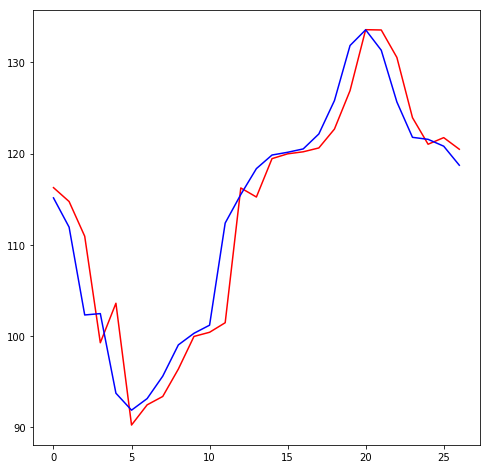

In [15]:
plt.figure(figsize=(8,8))
plt.plot(range(len(test)),predictions,color='r')
plt.plot(range(len(test)),test,color='b')
plt.show()

In [16]:
mse, mae

(15.235349713944588, 2.6557243253585456)

In [ ]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))